In [1]:
from pyrep import PyRep
import numpy as np
from matplotlib import pyplot as plt
from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape
from pyrep.objects.vision_sensor import VisionSensor
from IPython import display

In [2]:
from matplotlib import cm
cols = cm.get_cmap('tab20c', 7)

In [3]:
f = open("soma_cube.txt", "r")
text = f.read()

split_sols = text.split('solution')
solutions = [split_sols[j] for j in range(1,241)]

solution_list = []
pic_list = []
for s in solutions:

    parts = s.split('\n')[1:8]
    solution_list.append(parts)

In [4]:
class BlockSim:
    
    def __init__(self,move_tolerance=1e-3):
        
        self.pr = PyRep()
        self.pr.launch(headless=False)
        
        self.pr.start()
        
        self.move_tolerance = move_tolerance
        
        self.blocks = ['T','p','V','L','Z','b','a']
    
    def reset(self):
        
        self.pr.stop()
        
    def setup(self,actions):

        self.pr.start()

        cam0 = VisionSensor.create([64,64],position=[0.1,0.1,0.5],orientation=[np.pi,0,0])
        cam1 = VisionSensor.create([64,64],position=[0.5,0.1,0.1],orientation=[0,-np.pi/2,-np.pi/2])
        cam2 = VisionSensor.create([64,64],position=[0.1,0.5,0.1],orientation=[np.pi/2,0,0])
        cam3 = VisionSensor.create([64,64],position=[0.1,-0.3,0.1],orientation=[-np.pi/2,0,-np.pi])

        # Make cube for 
        self.obj_list = []
        self.block_order = []
        for i,a in enumerate(actions):
            col_idx = self.blocks.index(a[-1])
            self.block_order.append(a[-1])
            color = (cols.colors[col_idx][0:3]).tolist()

            pose = np.array(' '.join(a[0:-1].split(',')).split()).reshape(-1,3).astype(int)*0.05 + 0.05
            block_list = []
            for p in pose:
                obj = Shape.create(type=PrimitiveShape.CUBOID, 
                              color=color, size=[0.05, 0.05, 0.05],
                              position=p.tolist())
                obj.set_color(color)
                block_list.append(obj)
            self.obj_list.append(block_list)

        for j in range(10):
            self.pr.step()
            
        im0 = cam0.capture_rgb()
        im1 = cam1.capture_rgb()
        im2 = cam2.capture_rgb()
        im3 = cam3.capture_rgb()

        self.pr.step()
        
        return (im0,im1,im2,im3)

    def remove(self,piece):
        try:
            idx = self.block_order.index(piece)
            parts = self.obj_list[idx]
            for p in parts:
                p.remove()
        except:
            print('No such piece. Not Removed.')
        for j in range(2):
            self.pr.step()
        
        return self.check_moving()
            
    def check_moving(self):
        vels = []
        for p in self.obj_list:
            for block in p:
                try:
                    t,w = block.get_velocity()
                    vels.append(np.sum(t**2)+np.sum(w**2))
                            
                except:
                    vels.append(0)
        if np.sum(np.array(vels) > self.move_tolerance) > 1:
            self.collapsed = True
            return True 
        else:
            return False

In [5]:
sim = BlockSim()

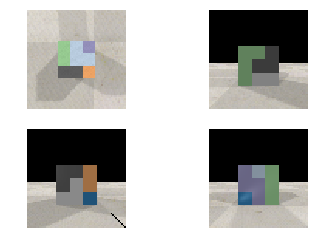

In [28]:
idx = 180
puzzle = solution_list[idx]
c = sim.setup(puzzle)

plt.clf()
plt.subplot(2,2,1)
plt.imshow(c[0])
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(c[1])
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(c[2])
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(c[3])
plt.axis('off')
plt.show()

In [30]:
for j in range(500):
    sim.pr.step()

In [31]:
key = {'Orange':'V','Green':'L','Black':'b','Purple':'Z','White':'a','LBlue':'p','Blue':'T'}

In [32]:
# Show Collapse
removal_list = ['Blue','Green','Black','Purple','LBlue','White','Orange']

for part in removal_list:
    collapsed = sim.remove(key[part])
    if collapsed:
        print('Collapse!')
        break;

In [27]:
sim.reset()

In [10]:
extraction_orders = np.genfromtxt('./extraction_order.txt',delimiter=',',dtype=str)

In [13]:
# Sanity check on manual labels

for i,puzzle in enumerate(solution_list):
    c = sim.setup(puzzle)
    
    removal_list = extraction_orders[i]
    
    collapsed = False
    for part in removal_list:
        collapsed = sim.remove(key[part])
        if collapsed:
            print('%d Collapsed!'%i)
        else:
            print('\r %d ok'%i,end='')
    sim.reset()
    
    


 239 ok

In [14]:
sim.pr.shutdown()